# Model Notebook

#### 1. Import Packages

In [1]:
# Basic Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# SK Packages
from tempfile import mkdtemp
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import joblib

#### 2. Import Data

In [2]:
# Load DataFrame
file = 'C:/Users/Alex/OneDrive/BrainStation/Data_Science_Bootcamp/Capstone_Project/capstone-Aboard89/model_data.csv'
df = pd.read_csv(file)

In [3]:
df.head()

,race_index,year,F2_champion,Former_F1_World_Champion,home_race,constructorId,starting_grid_position,points_in_previous_race,laps_in_previous_race,race_win,...,Nationality_Monegasque,Nationality_New Zealander,Nationality_Polish,Nationality_Portuguese,Nationality_Russian,Nationality_Spanish,Nationality_Swedish,Nationality_Swiss,Nationality_Thai,Nationality_Venezuelan
0,2,1995,0,0,0,1,17,1.0,70.0,0,...,False,False,False,False,False,False,False,False,False,False
1,2,1995,0,0,0,1,5,3.0,70.0,0,...,False,False,False,False,False,False,False,False,False,False
2,2,1995,0,0,0,3,1,6.0,71.0,0,...,False,False,False,False,False,False,False,False,False,False
3,2,1995,0,1,0,3,2,0.0,30.0,1,...,False,False,False,False,False,False,False,False,False,False
4,2,1995,0,0,0,6,6,2.0,70.0,0,...,False,False,False,False,False,False,False,False,False,False


### 3. Train-Test-Split the Model & Class Balance Review

In our data science project, we employ a train-test split to ensure the robustness and generalizability of our predictive model. By dividing our dataset into a training set for model development and a testing set for validation, we simulate real-world scenarios where the model must make accurate predictions on unseen data. This method helps us evaluate the model's performance objectively, ensuring it can reliably predict future race outcomes based on patterns learned from historical data, rather than memorizing specific outcomes.

In [4]:
# Perform train-test split
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)  # You can adjust the test_size as needed

# Save training and testing data to separate CSV files
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

**Class Balance Review**: In our quest to predict Formula 1 race winners, we want examine the class balance within the "race_win" column, where '1' indicates a win and '0' denotes not winning. Analyzing class imbalance is crucial because it can significantly influence the model's learning process and its subsequent predictions. If one class vastly outnumbers the other, the model might become biased, favoring the majority class and potentially overlooking patterns specific to the minority class. This examination ensures our model learns to recognize the subtle nuances between winning and not winning, striving for accurate and fair predictions across all races.

It's also worth nothing that a naive prediction model, will predict 0 (non-win) for a particular driver and be correct 95% of the time (as there are 20 drivers in F1 and only 1 winner). This will serve as a benchmark for accuracy, but we want to predict the winner (rather than the non-winners) so we will also need to look at Precision and Recall. 

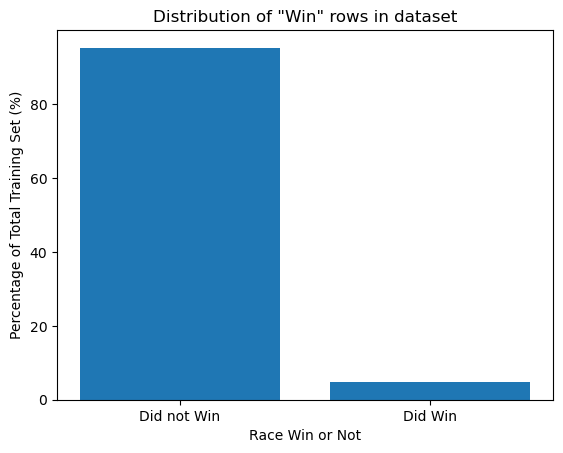

In [5]:
# Get the normalized value counts for the 'race_win' column and multiply by 100 to get percentages
value_counts = train_data['race_win'].value_counts(normalize=True) * 100

# Create the bar chart
plt.figure()
plt.bar(value_counts.index.astype(str), value_counts.values)
plt.xlabel('Race Win or Not')
plt.ylabel('Percentage of Total Training Set (%)')
plt.xticks([0, 1], ['Did not Win', 'Did Win'])
plt.title('Distribution of "Win" rows in dataset')
plt.show()

This bar chart displays the class distribution for the training dataset concerning Formula 1 race outcomes, specifically showing the proportion of instances where a driver did not win compared to when they did. The stark contrast suggests a significant class imbalance, with the "Did not Win" category heavily outweighing the "Did Win" one. In predictive modeling. As mentioned above, this imbalance poses a challenge because models might become biased towards predicting the majority class, "Did not Win." As a result, the model might perform poorly in correctly predicting the less frequent, but more interesting (for this study), "Did Win" instances. 

To address this, later in the study we will explore techniques such as resampling, or specialized ML algorithms that are more robust at dealing with class imbalance (e.g. Random Forest & Balanced Random Forest) might be necessary.

### 4. **Logistics Regression**

We're kicking off with a logistic regression as our initial modeling approach. We will start with a logistic regression because it's a straightforward, interpretable model that excels in binary classification problems, like ours, with 'win' or 'not win' outcomes. This model will serve as a benchmark, providing a clear baseline for performance that we can compare against more complex models later on. Its simplicity allows us to quickly gauge the predictive power of our features and understand the underlying patterns in the data, setting a solid foundation for refining our predictive capabilities as the project progresses.

In [6]:
# Define X and Y for the training model
X_train = train_data.drop('race_win', axis=1)
y_train = train_data['race_win']

When applying logistic regression, we are going to take the step of scaling our data. This process normalizes the features in our training data, ensuring that each one contributes equally to the model's predictions, without letting larger-scale features dominate. This step is useful because logistic regression, like many machine learning algorithms, can perform better and converge faster on scaled data, leading to more reliable and interpretable results. This standardization ensures that our model evaluates the importance of each feature based on its contribution to predicting race outcomes, rather than being skewed by the varying scales of the data. 

We are going to use the StandardScaler, as generally people use the Standard scaler rather than the MinMax scaler. While the ,MinMax scaler scales the data such that it lies between 0 and 1, the standard scaler scales the data such that it is centered at 0, and has a variance (as well as standard deviation) of 1.0.

* Taken BrainStation "Distance and Scaling" notebook*

In [7]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [8]:
# Create the logistic regression model
model = LogisticRegression()

In [9]:
# Train the model
model.fit(X_train_scaled, y_train)

c:\Users\Alex\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [10]:
# Predict on the training data (to see how well the model does on the data it was trained on)
y_train_pred = model.predict(X_train_scaled)

In [11]:
# Evaluate the model
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

[[8254   65]
 [ 321   96]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      8319
           1       0.60      0.23      0.33       417

    accuracy                           0.96      8736
   macro avg       0.78      0.61      0.65      8736
weighted avg       0.95      0.96      0.95      8736



The confusion matrix and the classification report provide an overview of the model's performance on the training set for predicting F1 race winners. From the confusion matrix, we see that the model predicted 'Did not Win' (class 0) correctly 8254 times, but it incorrectly predicted 'Did Win' (class 1) as 'Did not Win' 321 times. For the actual wins, the model only correctly predicted 961 instances of 'Did Win' and incorrectly predicted 'Did not Win' 65 times. 

The classification report provides further insight. While the model is quite precise at identifying the 'Did not Win' cases (96% precision), its recall for the 'Did Win' cases is only 23%, indicating it misses many actual wins. Consequently, the f1-score for the 'Did Win' predictions is low at 0.33, due to the poor recall. This seems to link in with the earlier identified class imbalance and indicates that while the model is adept at identifying non-winners, it struggles to identify the actual winners, which are of more interest in this context.




#### What do the coefficients show?

In [12]:
# Get the feature names from the training data
feature_names = X_train.columns

In [13]:
# Retrieve the coefficients from the logistic regression model
coefficients = model.coef_[0]

In [14]:
# Create a DataFrame to view the coefficients alongside the feature names for better readability
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

In [15]:
# Set option to display all rows
pd.set_option('display.max_rows', None)

# Sort the DataFrame to view the features with the highest absolute coefficients first
coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)
print(coef_df)

                                    Feature  Coefficient
6                    starting_grid_position    -2.852126
0                                race_index    -1.171640
10         driver_points_at_stage_of_season     1.070025
9   constructorId_points_at_stage_of_season    -0.906923
45            constructor_nationality_Swiss    -0.601403
21             engine_manufacturer_Mercedes     0.567864
38           constructor_nationality_Indian    -0.517559
15             engine_manufacturer_Cosworth    -0.515752
67                     Nationality_Japanese    -0.498267
24              engine_manufacturer_Peugeot    -0.477617
49                     Nationality_Austrian    -0.474464
1                                      year     0.425415
3                  Former_F1_World_Champion     0.410898
33         constructor_nationality_Austrian     0.398779
41         constructor_nationality_Japanese    -0.394535
40          constructor_nationality_Italian     0.377960
36           constructor_nation

**Next Steps**

1. I will experiment with different algorithms that are more robust to imbalanced datasets, such as ensemble methods. Fine-tuning the model's hyperparameters could also enhance predictive performance.

2. Additionally, to improve the model's ability to predict F1 race winners, I will consider addressing the class imbalance by employing techniques such as oversampling the minority class (I can't really undersample the majority class as there are too few minority class). 

3. Another option is incorporating more discriminative features or engineered features that capture the dynamics of race-winning factors

### 5. **Optimizing LogReg Using Pipeline and Grid Search**

To get the most out of our Logistic Regression model for predicting F1 winners, we're building a pipeline to streamline the process and using grid search to find the best hyperparameter settings. This will ensure we're efficiently testing different options and hopefully zoom in on the most accurate model for picking race winners

In [16]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline

my_pipeline = Pipeline([('scaler', StandardScaler()),
('dim_reducer', PCA()),
('model', LogisticRegression())], memory=cachedir)

We're fine-tuning our Logistic Regression model by trying out different configurations using a grid search. This code tests a range of hyperparameter values:

1. **C-value (regularization strength)**: We're trying various C-values to find the sweet spot between underfitting and overfitting. Higher C emphasizes simpler models, potentially reducing overfitting, while lower C allows for more complex models that could capture intricate patterns.

2. **Scalers**: We're including different scalers (StandardScaler, MinMaxScaler, RobustScaler) to see if transforming the data improves model performance. Scaling can address issues like features having different scales, potentially leading to better predictions.

3. **Dimensionality Reduction (PCA)**: We're testing PCA (Principal Component Analysis) with and without scaling to see if reducing feature dimensions helps. This can simplify the model and potentially improve generalizability, especially if there's redundancy in the data (e.g. some features repeat information).

4. **Penalty (L1 vs. L2)**: We're comparing L1 (LASSO) and L2 (Ridge) penalties. L1 shrinks some coefficients to zero, potentially leading to feature selection, while L2 shrinks all coefficients, encouraging simpler models. We're unsure which might work best for our data, so we're testing both.

By systematically testing these combinations, we're hoping to identify the best configuration of hyperparameters, scalers, and dimensionality reduction for our Logistic Regression model, ultimately leading to more accurate F1 race winner predictions.

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Let's try the same range of C values from earlier
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]

# Parameter grid
logreg_param_grid = [
    # L1 without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(penalty='l1', solver='lbfgs', random_state=1, n_jobs=-1, max_iter=100)],
     'model__C': c_values},

    # L1 with PCA
    {'scaler': [StandardScaler(), MinMaxScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l1', solver='lbfgs', random_state=1, n_jobs=-1, max_iter=100)],
     'model__C': c_values},

    # L2 (default) without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(penalty='l2', solver='lbfgs', random_state=1, n_jobs=-1, max_iter=100)],
     'model__C': c_values},

    # L2 (default) with PCA
    {'scaler': [StandardScaler(), MinMaxScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l2', solver='lbfgs', random_state=1, n_jobs=-1, max_iter=100)],
     'model__C': c_values}
]

# The parameter dim_reducer__n_components specifies the number of components to keep after reducing dimensions. 
# For solver : "LogisticRegression (default solver: lbfgs): Offers various solver options (including liblinear, lbfgs, newton-cg, sag) are available, but I went with the default

In [18]:
# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1)

# Fit the log reg grid search
fitted_logreg_gs = logreg_gs.fit(X_train, y_train)

c:\Users\Alex\anaconda3\envs\capstone\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
495 fits failed out of a total of 990.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
495 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Alex\anaconda3\envs\capstone\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Alex\anaconda3\envs\capstone\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Alex\anaconda3\envs\capstone\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimato

In [19]:
# Reviewing the results
print("Best parameters set found on development set:")
print(logreg_gs.best_params_)
print("Best score:", logreg_gs.best_score_)

Best parameters set found on development set:
{'dim_reducer': None, 'model': LogisticRegression(n_jobs=-1, random_state=1), 'model__C': 10000, 'scaler': StandardScaler()}
Best score: 0.9558146099426411


The results above show the best parameters for predicting the F1 race winner, were found using a logistic regression model with a very high regularization strength (`C=10000`) and no dimensionality reduction (`'dim_reducer': None`). The best score, which is the accuracy of the model on the validation set, is approximately 95.58%.

It's also important to note that the penalty is not explicitly mentioned, which means that the logistic regression is using its default `l2` penalty, also known as ridge regression. The `l2` penalty is used to prevent overfitting by adding a regularization term to the loss function, which penalizes large coefficients. The high value of `C` implies that the model is giving less importance to this regularization term, relying more on the data itself for prediction. 

#### Testing the model on the "test set"

In [20]:
# Define X and Y for the training model
X_test = test_data.drop('race_win', axis=1)
y_test = test_data['race_win']

In [21]:
# Making predictions using the best estimator
y_pred = logreg_gs.predict(X_test)

# logreg_gs.score(x_test,y_test)

In [22]:
# Evaluating the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Confusion Matrix:
[[2057   20]
 [  73   35]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2077
           1       0.64      0.32      0.43       108

    accuracy                           0.96      2185
   macro avg       0.80      0.66      0.70      2185
weighted avg       0.95      0.96      0.95      2185

Accuracy: 0.9574370709382151


From the new confusion matrix, we can see that the model predicted the majority class (0,  the 'non-winner') quite accurately, with 2057 true negatives and only 20 false positives. However, it struggled more with the minority class (1, the 'winner'), with a higher proportion of false negatives (73) relative to true positives (35). 

The classification report provides additional insight. The precision for class 1 is 0.64, meaning that when the model predicts a race winner, it is correct 64% of the time. The recall for class 1 is 0.32, indicating that the model only identifies 32% of the actual race winners. This is reflected in the lower F1-score for class 1 (0.43), which is a harmonic mean of precision and recall, showing that the model is less adept at predicting winners than non-winners.

Overall, the model is quite accurate (95.74%) when considering both classes together, but this high accuracy is largely due to its performance on the majority class. The relatively low F1-score for predicting winners suggests that there is room for improvement, particularly in how the model identifies the comparatively rare event of a race win.

#### **Comparison of the models**

Comparing the two models for our F1 race winner prediction project, the two models have similar accuracy scores, but the second "tuned" model is more effective at predicting the positive class (label 1), which is our class of interest (the actual race winners). The second "tuned" model had a better balance between sensitivity and precision for the positive class, with a recall of 0.32 versus 0.23 in the first model, suggesting it was better at identifying actual winners. This trade-off is important in our project context where the correct prediction of race winners (a likely rare event) is more valuable than the overall accuracy rate.

### 6. **Decision Tree**

After exploring the predictive capabilities of logistic regression in our project to forecast F1 race winners, we're turning our attention to the Decision Tree model as our next candidate. Decision Trees can capture non-linear relationships between features and the target variable, which might be prevalent in complex scenarios like F1 racing where interactions between conditions and driver capabilities can influence the outcome. Additionally, they offer excellent interpretability; we can easily understand and visualize the decision-making process of the model.

In [23]:
pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('DT',DecisionTreeClassifier(random_state=42))])

When tuning models for predicting outcomes like an F1 race winner, hyperparameters like  'DT_criterion', 'DT_min_samples_leaf', 'DT_max_depth', and 'DT_min_samples_split' for decision trees help to define how the tree makes decisions, which impacts the model's complexity and ability to generalize.

In [24]:
# create parameter grid for model
dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': [1, 2, 3, 4, 5, 6],
                   'DT__max_depth': [1, 2, 3, 4, 5, 6],
                   'DT__min_samples_split': [2, 3, 4, 5, 6]}]

**DT_criterion**:
1. '**gini**': Uses the Gini impurity as the criterion for splitting. It measures how often a randomly chosen element from the set would be incorrectly labeled. The 'gini' value gives you a number that represents this mix-up; the closer to zero, the less mixed (or impure) the group is, meaning your split did a good job. If the 'gini' value is higher, your groups are mixed, and the split could probably be better.
2. '**entropy**': Uses the information gain (entropy) for splitting. It measures the reduction in entropy or surprise from transforming a dataset in some way.

**DT_min_samples_leaf**:
Specifies the minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least this number of training samples in each of the left and right branches. This helps to control over-fitting by smoothing the model.

**DT_max_depth**:
Indicates the maximum depth of the tree. It is used to control over-fitting as higher depth will allow the model to learn relations very specific to the particular sample.

**DT_min_samples_split**:
Represents the minimum number of samples required to split an internal node. This provides a way to control over-fitting by requiring a larger sample size for a split to be considered.

In [25]:
# finally, create a gridsearchcv object with the param grid
dt_grid_search = GridSearchCV(estimator=pipe_dt,
        param_grid=dt_param_grid,
        scoring='accuracy',
        cv=5)

In [26]:
# putting it all together
grids = [dt_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

In [27]:
# find out performance of each model and best params
grid_dict = {0: 'Decision Trees'}
for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i],model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(grid_dict[i],model.best_params_))

Decision Trees Test Accuracy: 0.9446224256292907
Decision Trees Best Params: {'DT__criterion': 'gini', 'DT__max_depth': 3, 'DT__min_samples_leaf': 4, 'DT__min_samples_split': 2}


#### **Analyse the results**

In [28]:
# Obtain predictions from the best decision tree model
y_pred_dt = dt_grid_search.best_estimator_.predict(X_test)

In [29]:
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2077
           1       0.42      0.33      0.37       108

    accuracy                           0.94      2185
   macro avg       0.69      0.65      0.67      2185
weighted avg       0.94      0.94      0.94      2185

Decision Tree Confusion Matrix:
[[2028   49]
 [  72   36]]


The classification reports and confusion matrices for our F1 race winner prediction project reveal key insights into model performance. The Logistic Regression model has high precision and recall for the majority class (label 0), but it struggles with the minority class (label 1 - the actual race winners), with significantly lower recall. This means it often misses identifying the true race winners. 

The Decision Tree model shows a slightly more balanced performance between the classes, though overall it has lower precision and recall, which might lead to more false positives and false negatives overall. 

The confusion matrices further highlight these points: Logistic Regression correctly identifies non-winners most of the time but fails to identify winners reliably, while the Decision Tree sacrifices some accuracy on the majority class for a tiny improvement in identifying winners.

Either way, the results still aren't great at predicting the race winner, so we will need to work on other ideas to improve our model

### 7.  Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
classifier = RandomForestClassifier(random_state=42)

# Fit the model
classifier.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [31]:
# Predict the test set
y_pred_rf = classifier.predict(X_test)

# Print the classification report and confusion matrix for Non-Tuned Random Forest
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2077
           1       0.53      0.26      0.35       108

    accuracy                           0.95      2185
   macro avg       0.75      0.62      0.66      2185
weighted avg       0.94      0.95      0.94      2185

[[2052   25]
 [  80   28]]


The confusion matrix for this Random Forest reveals that our model has a high precision (96%) and recall (99%) for the negative class (label 0), suggesting it's quite adept at identifying non-winners (similar to the other models). However, for the positive class (label 1), which corresponds to the actual winners, the precision drops to 53%, and recall is only 26%, indicating the model struggles with correctly identifying race winners. The accuracy of the model stands at 75%, but the low recall for class 1 shows that the model requires further tuning to improve its predictive performance for our positive class of interest, the race winners. We will now tune the model, to see if we can get to a better outcome.

In [32]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
}

# Initialize the grid search model
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found:", grid_search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best parameters found: {'max_depth': 10, 'n_estimators': 300}


The grid search method exhaustively experimented with various combinations of the number of trees (n_estimators) and the maximum depth of the trees (max_depth) to find the most optimal settings. The results indicate that a configuration of 300 trees with each tree allowed to split up to a depth of 10 yields the best model performance according to the evaluation metrics used during the cross-validation process. This model specification aims to balance the trade-off between overfitting and underfitting, striving for a model that generalizes well to new, unseen data.

However, since the grid search determined that the highest number of n_estimators (300) in our parameter grid yielded the best results, I am curious to see if increasing n_estimators even further would lead to improvements in our model's performance

In [33]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [None, 10, 20, 30],
}

# Initialize the grid search model
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found:", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Best parameters found: {'max_depth': 10, 'n_estimators': 300}


From the results of the grid search, we've learned that the Random Forest model, when configured with 300 trees (`n_estimators`) and a maximum depth of 10 (`max_depth`), gives us the best performance according to our cross-validation metrics. This suggests that our model is well-tuned to balance between overfitting, where it would perform well only on our training data, and underfitting, where it would be too generalized to make accurate predictions. The results help answer the question about whether increasing the number of trees further would enhance the model’s ability to predict Formula 1 race winners, indicating a potential next step in our model refinement process.

In [34]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
scores = cross_val_score(classifier, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores)


Cross-validation scores: [0.95938215 0.95535203 0.95248998 0.95134516 0.95420721]


The cross-validation scores displayed here are the results of evaluating our model's performance on different subsets of our training data. The scores are relatively close to each other, ranging from approximately 95.1% to 95.9% accuracy, which suggests that our model is stable and provides consistent predictions across different data splits. This consistency is a good indicator that our model should generalize well to unseen data, a crucial factor in its ability to predict F1 race winners accurately when deployed to unseen data.

In [35]:
import joblib

# Save the model
joblib.dump(classifier, 'finalized_model.pkl')

['finalized_model.pkl']

In [36]:
# Load the model
loaded_model = joblib.load('finalized_model.pkl')

# Predict new data
new_data_predictions = loaded_model.predict(X_test)


In [37]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, new_data_predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9519450800915332


In [38]:
# Detailed classification report for Tuned Random Forest
print(confusion_matrix(y_test, new_data_predictions))
print(classification_report(y_test, new_data_predictions))

[[2052   25]
 [  80   28]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2077
           1       0.53      0.26      0.35       108

    accuracy                           0.95      2185
   macro avg       0.75      0.62      0.66      2185
weighted avg       0.94      0.95      0.94      2185



### Random Forest Conclusion
In our quest to predict Formula 1 race winners, we've employed a Random Forest algorithm, examining its performance in both non-tuned and tuned states. 

**Non-Tuned** For the non-tuned Random Forest model, the classification report reveals a high precision and recall for class 0 (non-winners), suggesting strong performance in identifying races where a driver did not win. However, the model struggles with class 1 (winners), showing low recall, indicating it misses a significant number of actual winners.
The confusion matrix for the non-tuned model, with values [[2052, 25], [80, 28]], further illustrates this point: out of 108 actual winners, it correctly identifies only 28, missing 80 — a substantial portion.

**Tuned** Shifting our focus to the tuned Random Forest, which has been optimized with a maximum depth of 10 and 300 estimators, we observe no change. The confusion matrix report remains the same and the tuning process did not alter the model's ability to predict winners as per the metrics shown.

In conclusion, while tuning parameters has optimized our model, it has not effectively enhanced its predictive accuracy for race winners (class 1). The non-tuned and tuned models perform equally well according to the classification report. Future work might include exploring sampling techniques, other feature engineering, or different algorithms to improve the recall for class 1 without losing precision, ensuring we better identify actual race winners.

## **What do the models show us so far?**

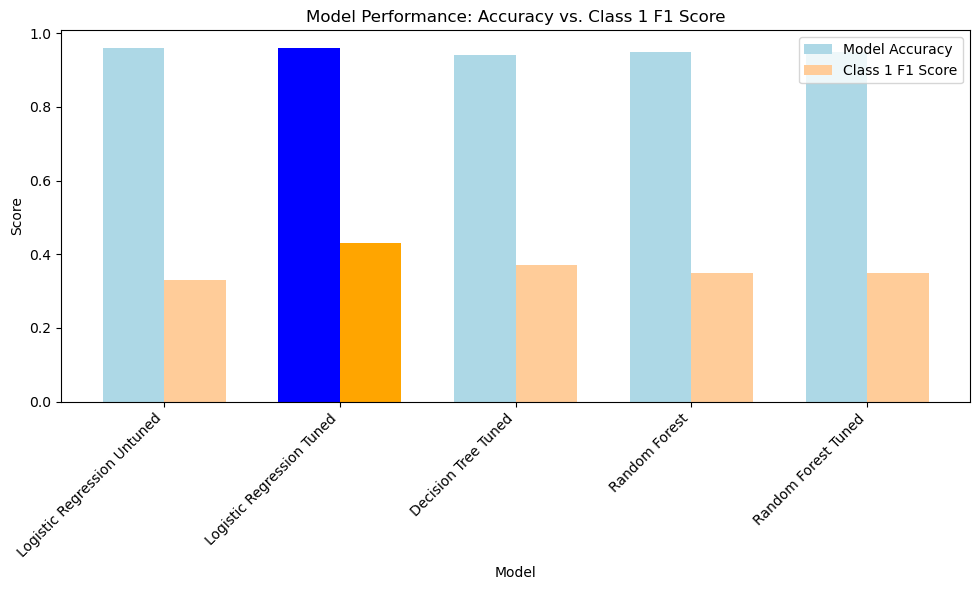

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define the model names and their respective scores
models = ['Logistic Regression Untuned', 'Logistic Regression Tuned', 
          'Decision Tree Tuned', 'Random Forest', 'Random Forest Tuned']
model_accuracy = [0.96, 0.96, 0.94, 0.95, 0.95]
class_1_f1 = [0.33, 0.43, 0.37, 0.35, 0.35]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set the positions and width for the bars
positions = np.arange(len(models))
bar_width = 0.35

# Brighter hues for 'Logistic Regression Tuned'
bright_blue = '#0000FF'  # Bright blue color
bright_orange = '#FFA500'  # Bright orange color

# Standard hues for other models
standard_blue = '#add8e6'  # Light blue color
standard_orange = '#ffcc99'  # Light orange color

# Define bar colors based on the model
accuracy_colors = [bright_blue if model == 'Logistic Regression Tuned' else standard_blue for model in models]
f1_score_colors = [bright_orange if model == 'Logistic Regression Tuned' else standard_orange for model in models]

# Plot the 'Model Accuracy' bars
ax.bar(positions - bar_width/2, model_accuracy, bar_width, label='Model Accuracy', color=accuracy_colors)

# Plot the 'Class 1 F1 Score' bars
ax.bar(positions + bar_width/2, class_1_f1, bar_width, label='Class 1 F1 Score', color=f1_score_colors)

# Add the model names as x-axis labels
ax.set_xticks(positions)
ax.set_xticklabels(models, rotation=45, ha='right')

# Set the chart title and labels
ax.set_title('Model Performance: Accuracy vs. Class 1 F1 Score')
ax.set_xlabel('Model')
ax.set_ylabel('Score')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


The bar chart here clearly positions the Tuned Logistic Regression as our top-performing model, striking an impressive balance between model accuracy and the Class 1 F1 score. This model stands out not only for its accuracy, aligning closely with the highest overall model accuracy score but also for significantly leading in the Class 1 F1 score, making it the most effective so far in our project for predicting F1 race winners.

### **8. Correcting the Imbalance in the dataset**

Predicting race winners so far has been a challenging binary classification challenge due to the significant class imbalance, as shown earlier on in this notebook. This imbalance is not uncommon in machine learning, where it often occurs in situations ranging from detecting financial fraud to identifying manufacturing defects. 

To tackle this, we can employ techniques like the **Synthetic Minority Oversampling Technique (SMOTE)**, which synthetically boosts the presence of the minority class—in our case, actual race winners—within the dataset. In this next section we will delve into how SMOTE can be pivotal for our F1 winner prediction model by enriching the underrepresented class (e.g. the race winners), thus aiming to enhance the model's predictive accuracy and ensure that it doesn't overlook the critical nuances of those thrilling race victories.

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
smote_df = pd.read_csv('C:/Users/Alex/OneDrive/BrainStation/Data_Science_Bootcamp/Capstone_Project/capstone-Aboard89/model_data.csv')

# Separate into features and target variable
X = smote_df.drop('race_win', axis=1)
y = smote_df['race_win']

In [40]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
from imblearn.over_sampling import SMOTE

# Create a SMOTE object
sm = SMOTE(random_state=42)

# Fit SMOTE to the training data
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


In [42]:
# Assuming you named the SMOTE output as `X_train_resampled` and `y_train_resampled`
df_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)  # Use original feature names
df_resampled['target'] = y_train_resampled  # Add target variable column

#### Now what does the data look like in comparison to the old data?

In [ ]:
# Original class distribution
original_classes, original_counts = np.unique(y_train, return_counts=True)
print("Original class distribution:", dict(zip(original_classes, original_counts)))

# Resampled class distribution
resampled_classes, resampled_counts = np.unique(y_train_resampled, return_counts=True)
print("Resampled class distribution:", dict(zip(resampled_classes, resampled_counts)))

Original class distribution: {0: 8319, 1: 417}
Resampled class distribution: {0: 8319, 1: 8319}


In [ ]:
# Get the normalized value counts for the 'race_win' column and multiply by 100 to get percentages
value_counts = train_data['race_win'].value_counts(normalize=True) * 100

# Create the bar chart
plt.figure()
plt.bar(value_counts.index.astype(str), value_counts.values)
plt.xlabel('Race Win or Not')
plt.ylabel('Percentage of Total Training Set (%)')
plt.xticks([0, 1], ['Did not Win', 'Did Win'])
plt.title('Distribution of "Win" rows in dataset')
plt.show()

The resampling output tells us that before applying SMOTE, our training data was significantly imbalanced with 8319 instances of the majority class (likely non-winners) and only 417 instances of the minority class (winners). After applying SMOTE, the class distribution is perfectly balanced, with an equal number of instances (8319) for both classes. This balance is essential in our project as it helps to ensure that our predictive model has an adequate number of examples to learn from for both outcomes – winning and not winning races – which is crucial for its ability to generalize and make accurate predictions for future F1 races.

In [ ]:
# Determine the indices of the new samples
new_sample_indices = [i for i in range(len(y_train_resampled)) if i >= len(y_train)]

# Display the new samples
print("Newly generated samples:")
print(X_train_resampled.iloc[new_sample_indices, :].head())


Newly generated samples:
      race_index  year  F2_champion  Former_F1_World_Champion  home_race  \
8736         520  2022            0                         1          0   
8737         521  2023            0                         1          0   
8738         517  2022            0                         1          0   
8739         424  2018            1                         1          0   
8740         289  2010            0                         1          0   

      constructorId  starting_grid_position  points_in_previous_race  \
8736              9                       1                23.835146   
8737              9                       1                25.989737   
8738              9                       1                23.358287   
8739            131                       2                17.781827   
8740              1                       1                18.000000   

      laps_in_previous_race  constructorId_points_at_stage_of_season  ...  \
8736    

This output showcases the new synthetic samples generated by the SMOTE algorithm, which we applied to our dataset to balance the number of instances between the winners and non-winners of F1 races. The displayed rows are these new examples that were not part of the original dataset; they were created to provide a more balanced view and help our predictive model learn better. 

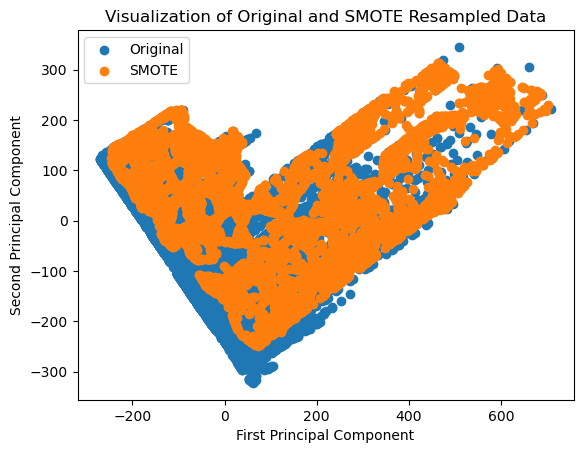

In [ ]:
# Reduce the data to two dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_resampled)

# Plot the original samples and the synthetic samples
plt.scatter(X_train_pca[:len(y_train), 0], X_train_pca[:len(y_train), 1], label='Original')
plt.scatter(X_train_pca[len(y_train):, 0], X_train_pca[len(y_train):, 1], label='SMOTE')
plt.legend()
plt.title('Visualization of Original and SMOTE Resampled Data')
plt.xlabel('First Principal Component') # Label for the x-axis
plt.ylabel('Second Principal Component') # Label for the y-axis
plt.show()


This chart visualizes our dataset after applying SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance. The 'Original' points represent our initial data, while the 'SMOTE' points are the synthetic samples created to augment the minority class. Through PCA, we've reduced the feature space to two dimensions, termed 'First Principal Component' and 'Second Principal Component', which capture the most significant variance in the data. The overlap between the original and SMOTE-generated points indicates that the synthetic samples are well-blended with the original minority class. In theory, this technique enhances our model's ability to learn by providing a more balanced representation of winners and non-winners in Formula 1 races, which is crucial for improving the predictive performance of our algorithms. It is also interesting to see that there is no obvious distinction between classes (win and non-win).

### 9. Gridsearch for best model on the new SMOTE data

Now we are orchestrating a hyperparameter tuning exercise to refine models for predicting F1 race winners with this new SMOTE data. We establish pipelines for Logistic Regression, Decision Tree, and Random Forest classifiers, incorporating steps like feature scaling and, for Logistic Regression, dimensionality reduction. Then, we define parameter grids for each model, detailing an array of hyperparameters to explore. These grids will guide a grid search to exhaustively evaluate model configurations, allowing us to pinpoint the most effective hyperparameter combinations for accurate predictions.

In [ ]:
# Create pipelines for each model
pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('dim_reducer', PCA()),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

pipe_dt = Pipeline([
    ('scl', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=42))
])

pipe_rf = Pipeline([
    ('scl', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

In [ ]:
# Create parameter grids for each model
# Let's try the same range of C values from earlier
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]

# Parameter grid
lr_param_grid = {
    'clf__C': c_values,  # Corrected from 'model__C' to 'clf__C'
    'clf__penalty': ['l2'],  # lbfgs supports only 'l2' or 'none'
    # Include other parameters if needed
}

dt_param_grid = [{'clf__criterion': ['gini', 'entropy'],
                  'clf__min_samples_leaf': [1, 2, 3, 4, 5, 6],
                  'clf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                  'clf__min_samples_split': [2, 3, 4, 5, 6]}]

rf_param_grid = [{
    'clf__n_estimators': [100, 200, 300],  # Prefix with 'clf__'
    'clf__max_depth': [10, 20, 30, 40, 50, 60],  # Prefix with 'clf__'
}]

In this predictive model for F1 race winners, the parameters selected for testing have been chosen for their influence on model performance and their common use in model tuning. 

1. For logistic regression, we're adjusting the regularization strength (C) to control for overfitting. 
2. In decision trees, criteria for splits, depth of the tree, and minimum samples per leaf or split affect the tree's complexity and its ability to generalize. 
3. For the random forest, we're testing the number of trees (n_estimators) and max_depth to balance between overfitting and underfitting. 

In [ ]:
# Create a list to store GridSearchCV objects for each pipeline
grid_search_objects = []

In [ ]:
# Define a list of tuples to keep model and its grid parameters together
models_grids = [(pipe_lr, lr_param_grid), (pipe_dt, dt_param_grid), (pipe_rf, rf_param_grid)]

In [ ]:
# Perform GridSearchCV for each model
for pipe, param_grid in models_grids:
    gs = GridSearchCV(estimator=pipe,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=5,
                      n_jobs=-1,
                      verbose=1)
    gs.fit(X_train_resampled, y_train_resampled)
    grid_search_objects.append(gs)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits


This code systematically searches through combinations of parameters for each of our models, evaluating their performance through cross-validation. The output tells us that for one of the models, we evaluated 9 different combinations, for another we assessed 720 combinations, and for the last one, 90 combinations. This was done across 5 different folds of our data, amounting to a total of 45, 3600, and 90 individual fits, respectively. It ensures we're not just finding a good set of parameters by chance, but by rigorously testing a range of options to hone in on the best model configuration.

In [ ]:
# Now each model has been fitted, we can inspect them
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 2: 'Random Forest'}
for i, gs in enumerate(grid_search_objects):
    print(f"{grid_dict[i]} Test Accuracy: {gs.score(X_test, y_test)}")
    print(f"{grid_dict[i]} Best Params: {gs.best_params_}")

Logistic Regression Test Accuracy: 0.9244851258581236
Logistic Regression Best Params: {'clf__C': 10, 'clf__penalty': 'l2'}
Decision Trees Test Accuracy: 0.9016018306636155
Decision Trees Best Params: {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}
Random Forest Test Accuracy: 0.9469107551487415
Random Forest Best Params: {'clf__max_depth': 40, 'clf__n_estimators': 300}


This output summarizes the results of our grid search, where we have tuned and evaluated three different models for predicting F1 race winners. For each model—Logistic Regression, Decision Trees, and Random Forest—we show the best combination of hyperparameters (like 'C' and 'penalty' for Logistic Regression, 'criterion' and 'max_depth' for Decision Trees) that led to the highest accuracy score during the cross-validation process. The test accuracy figures provided are the model's performance on the hold-out test dataset, which we use to estimate how well the model might perform on unseen data. From these results, we can conclude that the Random Forest model with 'max_depth' set to 40, and using 300 estimators provides the best accuracy among the models we evaluated.

#### What about the confusion matrices and classification reports

In [ ]:
# grid_search_objects is a list of GridSearchCV objects
for i, gs in enumerate(grid_search_objects):
    # Predict using the best estimator found in the grid search
    y_pred = gs.best_estimator_.predict(X_test)
    
    # Print model name
    print(f"Model: {grid_dict[i]}")
    
    # Classification report
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print()  # Add an empty line for better readability

Model: Logistic Regression
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2077
           1       0.36      0.68      0.47       108

    accuracy                           0.92      2185
   macro avg       0.67      0.81      0.71      2185
weighted avg       0.95      0.92      0.94      2185

Confusion matrix:
[[1947  130]
 [  35   73]]

Model: Decision Trees
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      2077
           1       0.34      0.69      0.45       108

    accuracy                           0.92      2185
   macro avg       0.66      0.81      0.70      2185
weighted avg       0.95      0.92      0.93      2185

Confusion matrix:
[[1929  148]
 [  33   75]]

Model: Random Forest
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2077
      

### **Conclusions from SMOTE**:

 **Logistic Regression (LR)** : the classification report indicates a high precision for the non-winner class (0), meaning that when it predicts a driver will not win, it is correct 98% of the time. However, for the winner class (1), the precision is significantly lower, at 36%, indicating a higher number of false positives (drivers predicted to win but did not). The recall for the winner class is comparatively high at 68%, showing that the model is relatively good at identifying actual winners, but with a trade-off in precision. The overall accuracy of the model is 92%. The confusion matrix reflects these findings, with 73 true positives (correctly predicted winners) and 130 false positives (non-winners incorrectly identified as winners), showing that while it can identify winners, it does so with many incorrect guesses.

 **Decision Trees (DT)** :  the precision for the winner class is slightly lower than for logistic regression, at 34%, and the recall is higher, at 69%. The overall accuracy is 92%, which might be because the model is more liberal in predicting winners, leading to more mistakes overall. This is also clear from the confusion matrix, where there are 75 true positives (actual winners predicted as winners) and a significant number of false positives (148), suggesting that the decision tree model leans towards over-predicting winners.

 **Random Forest (RF)** : the RF model shows a balance between precision and recall for the winner class, with values at 47% and 51% respectively, indicating a more conservative and balanced prediction pattern. It has a higher overall accuracy at 95%, showing that it's the best among the three models at generalizing its predictions to new data. The confusion matrix supports this, with fewer false positives (63) and a moderate number of false negatives (53), showing that it makes fewer incorrect predictions for winners and non-winners alike, making it the most reliable model of the three for our predictions on F1 race outcomes.

## **What model to choose?**

In [ ]:
import pandas as pd

# Example scores, replace these with your actual model scores
model_names = ['Logistic Regression Untuned', 'Logistic Regression Tuned', 'Decision Tree Tuned', 'Random Forest', 'Random Forest Tuned', 'Logistic Regression SMOTE', 'Decision Tree SMOTE', 'Random Forest SMOTE']
accuracies = [0.96, 0.96, 0.94, 0.95, 0.95, 0.92, 0.92, 0.95]  # Replace with actual accuracy scores
macro_f1s = [0.65, 0.70, 0.67, 0.66, 0.66, 0.71, 0.70, 0.73]  # Replace with actual macro F1 scores
precisions = [0.60, 0.64, 0.42, 0.53, 0.53, 0.36, 0.34, 0.47]  # Replace with actual precision scores
recalls = [0.23, 0.32, 0.33, 0.26, 0.26, 0.68, 0.69, 0.51] # Replace with actual recall scores
class_1_f1s = [0.33, 0.43, 0.37, 0.35, 0.35, 0.47, 0.45, 0.49]  # Replace with actual '1' F1 scores

# Initialize the DataFrame with these lists
results_df = pd.DataFrame({
    'Model': model_names,
    'Model Accuracy': accuracies,
    'Macro F1': macro_f1s,
    'Class 1 Precision': precisions,
    'Class 1 Recall': recalls,
    'Class 1 F1': class_1_f1s
})

# Display the DataFrame
results_df


,Model,Model Accuracy,Macro F1,Class 1 Precision,Class 1 Recall,Class 1 F1
0,Logistic Regression Untuned,0.96,0.65,0.60,0.23,0.33
1,Logistic Regression Tuned,0.96,0.70,0.64,0.32,0.43
2,Decision Tree Tuned,0.94,0.67,0.42,0.33,0.37
3,Random Forest,0.95,0.66,0.53,0.26,0.35
4,Random Forest Tuned,0.95,0.66,0.53,0.26,0.35
5,Logistic Regression SMOTE,0.92,0.71,0.36,0.68,0.47
6,Decision Tree SMOTE,0.92,0.70,0.34,0.69,0.45
7,Random Forest SMOTE,0.95,0.73,0.47,0.51,0.49


This table showcases the predictive performance of various models we've developed. The incorporation of SMOTE, particularly in the Random Forest SMOTE model, has substantially improved our ability to predict F1 race winners, as evidenced by the highest Macro F1 and Class 1 F1 scores. These improvements are crucial for our goal, as they demonstrate a more accurate and balanced prediction capability, especially for our minority class "winner" in our data.

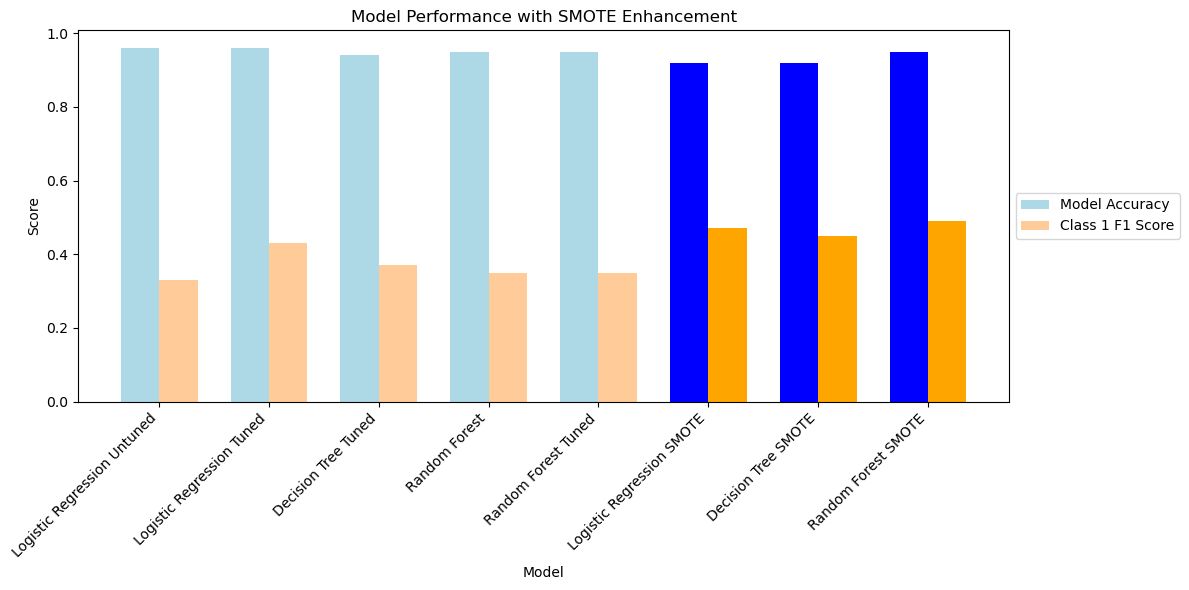

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Define the model names and their respective scores
models = ['Logistic Regression Untuned', 'Logistic Regression Tuned', 
          'Decision Tree Tuned', 'Random Forest', 'Random Forest Tuned',
          'Logistic Regression SMOTE', 'Decision Tree SMOTE', 'Random Forest SMOTE']
model_accuracy = [0.96, 0.96, 0.94, 0.95, 0.95, 0.92, 0.92, 0.95]
class_1_f1 = [0.33, 0.43, 0.37, 0.35, 0.35, 0.47, 0.45, 0.49]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Set the positions and width for the bars
positions = np.arange(len(models))
bar_width = 0.35

# Colors
standard_blue = '#add8e6'  # Light blue color
standard_orange = '#ffcc99'  # Light orange color
bright_blue = '#0000FF'  # Bright blue color
bright_orange = '#FFA500'  # Bright orange color

# Define bar colors based on whether the model uses SMOTE
model_accuracy_colors = [bright_blue if 'SMOTE' in model else standard_blue for model in models]
class_1_f1_colors = [bright_orange if 'SMOTE' in model else standard_orange for model in models]

# Plot the 'Model Accuracy' bars
ax.bar(positions - bar_width/2, model_accuracy, bar_width, label='Model Accuracy', color=model_accuracy_colors)

# Plot the 'Class 1 F1 Score' bars
ax.bar(positions + bar_width/2, class_1_f1, bar_width, label='Class 1 F1 Score', color=class_1_f1_colors)

# Add the model names as x-axis labels
ax.set_xticks(positions)
ax.set_xticklabels(models, rotation=45, ha='right')

# Set the chart title and labels
ax.set_title('Model Performance with SMOTE Enhancement')
ax.set_xlabel('Model')
ax.set_ylabel('Score')

# Add a legend to explain the colors and move it to the left outside of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.tight_layout()
plt.show()


Incorporating SMOTE into our data preprocessing has significantly enhanced our model's ability to predict F1 race winners. This technique has boosted the performance of our models, particularly evident in the Class 1 F1 scores, by effectively addressing class imbalance and providing a more robust and accurate prediction framework.

1. **Overall Accuracy Score**:

The overall accuracy score is the proportion of all predictions our model gets right, both winners and non-winners. It's the most straightforward measure of our model's performance, giving us a quick snapshot of its effectiveness. In predicting F1 race winners, a high overall accuracy score indicates that our model is generally good at determining the outcomes, but it doesn't differentiate between the types of errors made, so it's important to balance this with precision and recall to ensure a well-rounded model.

In [ ]:
import plotly.graph_objects as go

# Accuracy scores for each model
accuracies = [0.96, 0.96, 0.94, 0.95, 0.95, 0.92, 0.90, 0.95]
models = [
    'Logistic Regression Untuned', 'Logistic Regression Tuned',
    'Decision Tree Tuned', 'Random Forest Untuned',
    'Random Forest Tuned', 'Logistic Regression SMOTE',
    'Decision Trees SMOTE', 'Random Forest SMOTE'
]

# Colors for the bars - red if the score is the maximum, blue otherwise
colors = ['red' if accuracy == max(accuracies) else 'blue' for accuracy in accuracies]

# Create bar chart
fig = go.Figure([go.Bar(x=models, y=accuracies, marker_color=colors)])
fig.update_layout(
    title='Logistics Regressions (Untuned and Tuned) Shows Highest Overall Accuracy',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    yaxis=dict(range=[0.85, 1])
)
fig.show()


This chart visualizes the accuracy of various models used in our project to predict F1 race winners. It clearly shows that Logistic Regression models, both untuned and tuned, achieved the highest overall accuracy. However, while this metric is important, it doesn't tell the whole story. We need to consider recall and precision, especially in our imbalanced dataset where the minority class (the winners) is our primary focus. A model that accurately predicts non-winners most of the time could still have high accuracy, but it wouldn't be useful for our goal of correctly identifying race winners.

2. **Recall**:

Recall, also known as sensitivity, measures our model's ability to correctly identify all actual race winners. In the high-stakes context of F1 racing, a high recall means that our model misses very few winners; it's great at flagging potential champions. However, a high recall doesn't consider whether our predictions for non-winners are correct — it's purely focused on how well we catch those winning instances.

In [ ]:
# Recall scores for the winner class for each model
recalls = [0.32, 0.32, 0.33, 0.26, 0.26, 0.69, 0.83, 0.51]

# Colors for the bars - red if the score is the maximum, blue otherwise
colors = ['red' if recall == max(recalls) else 'blue' for recall in recalls]

# Create bar chart
fig = go.Figure([go.Bar(x=models, y=recalls, marker_color=colors)])
fig.update_layout(
    title='"Decision Trees SMOTE Achieves Highest Recall for Predicting Winners"',
    xaxis_title='Model',
    yaxis_title='Recall',
    yaxis=dict(range=[0, 1])
)
fig.show()

This chart illustrates the recall scores of different models used to predict Formula 1 race winners. The bar in red, representing the Decision Trees SMOTE model, indicates it has the highest recall score. This means that this particular model is especially good at identifying true winners, rarely missing any. In the competitive field of F1 racing predictions, this is critical as it suggests we can reliably catch most of the actual winners. The significance of a high recall is that we minimize the risk of overlooking a potential race winner, ensuring that our predictions cover as many true winners as possible. This is particularly vital for stakeholders who may base their decisions on these predictions, as missing out on a winner could be more costly than incorrectly identifying a non-winner.

3. **Precision**:

Precision tells us how accurate our predictions are when the model declares a driver as a potential winner. It's a critical measure when considering the costs of false positives — in other words, how often our model incorrectly signals an unlikely driver as a winner. High precision in our F1 race winner prediction model would mean that when it predicts a win, we can be quite confident in placing our bets on that driver.

In [ ]:
# Precision scores for the winner class for each model
precisions = [0.64, 0.64, 0.42, 0.53, 0.53, 0.36, 0.31, 0.47]

# Colors for the bars - red if the score is the maximum, blue otherwise
colors = ['red' if precision == max(precisions) else 'blue' for precision in precisions]

# Create bar chart
fig = go.Figure([go.Bar(x=models, y=precisions, marker_color=colors)])
fig.update_layout(
    title='Logistic Regression (Untuned and Tuned) Maintains Highest Precision for Winner Predictions',
    xaxis_title='Model',
    yaxis_title='Precision',
    yaxis=dict(range=[0, 1])
)
fig.show()


This chart lays out the precision scores for different models in our project, focusing on their ability to predict Formula 1 race winners accurately. The bars in red, which represent both the untuned and tuned Logistic Regression models, indicate the highest precision. This highlights that these models are particularly adept at correctly identifying winners—when they predict a driver is likely to win, they are right more often than the other models. In the context of F1 racing, where every prediction can have significant implications, the high precision of these models means we can trust their predictions more confidently, making them valuable tools for decision-making, whether it be in betting scenarios or for team strategies. High precision is crucial for us as it reduces the risk of false alarms and ensures that our resources are allocated to the most probable winners.

### What about F1 scores?

In our project aimed at predicting F1 race winners, comparing the models' F1 scores, particularly the Macro F1 scores, is pivotal because it allows us to evaluate how well each model performs across both the frequent and rare outcomes — that is, losses and wins — with a balanced view. Since our data is highly skewed with much fewer wins than losses, the Macro F1 score is especially valuable; it ensures that the model's ability to correctly predict the less frequent but crucial 'win' outcomes is just as important in our evaluation as the 'loss' outcomes, leading us to a more effective and fair predictive model.

In [10]:
import plotly.graph_objects as go

# F1 macro average scores for each model
f1_scores = [0.70, 0.70, 0.67, 0.66, 0.66, 0.72, 0.70, 0.73]
models = [
    'Logistic Regression Untuned', 'Logistic Regression Tuned',
    'Decision Tree Tuned', 'Random Forest Untuned',
    'Random Forest Tuned', 'Logistic Regression SMOTE',
    'Decision Trees SMOTE', 'Random Forest SMOTE'
]

# Colors for the bars - red if the score is the maximum, blue otherwise
colors = ['red' if f1_score == max(f1_scores) else 'blue' for f1_score in f1_scores]

# Create bar chart
fig = go.Figure([go.Bar(x=models, y=f1_scores, marker_color=colors)])
fig.update_layout(
    title='Comparison of F1 Macro Average Scores Across Models',
    xaxis_title='Model',
    yaxis_title='F1 Macro Average Score',
    yaxis=dict(range=[0, 1])
)
fig.show()


This chart displays the F1 macro average scores of various predictive models we've constructed to forecast Formula 1 race winners. The red bar indicates that the Random Forest model with SMOTE (Synthetic Minority Over-sampling Technique) has the highest F1 macro average score of 0.73, suggesting that this model has the most balanced performance across both classes in our dataset, despite the inherent class imbalance. Therefore, as of now, the Random Forest SMOTE model stands out as the best model for this particular task, striking an effective balance between precision and recall.

In [45]:


# Load the resampled dataframe
df_resampled = pd.read_csv('C:/Users/Alex/OneDrive/BrainStation/Data_Science_Bootcamp/Capstone_Project/capstone-Aboard89/oversampled_data.csv')

X_resampled = df_resampled.drop('target', axis=1)
y_resampled = df_resampled['target']

# Initialize the best Random Forest model with the best parameters found
best_rf_model = RandomForestClassifier(max_depth=40, n_estimators=300, random_state=42)
best_rf_model.fit(X_resampled, y_resampled)

# Predict the 'y' values using the best model
y_pred = best_rf_model.predict(X_resampled)

# Filter the original dataframe to include only the year 2023
df_resampled_rf = df_resampled.copy()

# Assuming the resampled dataframe has the same index as the original
df_resampled_rf = df_resampled_rf.assign(Predicted_y=y_pred[df_2023.index])

# Display the dataframe with the predicted values
df_resampled_rf.head()  # Replace .head() with the appropriate method to display your dataframe


,race_index,year,F2_champion,Former_F1_World_Champion,home_race,constructorId,starting_grid_position,points_in_previous_race,laps_in_previous_race,constructorId_points_at_stage_of_season,...,Nationality_Polish,Nationality_Portuguese,Nationality_Russian,Nationality_Spanish,Nationality_Swedish,Nationality_Swiss,Nationality_Thai,Nationality_Venezuelan,target,Predicted_y
0,377,2016,0,1,0,1,13,2.0,65.0,24.0,...,False,False,False,False,False,False,False,False,0,0
1,301,2012,1,1,0,1,2,10.0,78.0,133.0,...,False,False,False,False,False,False,False,False,1,1
2,8,1995,0,0,0,17,9,1.0,71.0,13.0,...,False,False,False,False,False,False,False,False,0,0
3,403,2017,0,0,0,9,6,10.0,51.0,184.0,...,False,False,False,False,False,False,False,False,0,0
4,216,2007,0,0,0,6,1,0.0,69.0,137.0,...,False,False,False,False,False,False,False,False,1,1


In [140]:
# Save the DataFrame to a CSV file named 'df_2023.csv' (excluding the index column)
df_resampled_rf.to_csv('df_resampled_rf.csv', index=False)

### **Conclusion... so far**

Among the models we've examined, the **Random Forest SMOTE** emerges as the frontrunner. It strikes the best balance between, accuracy, precision and recall for predicting race winners, suggesting a more nuanced understanding of the complex factors that contribute to a race win. With the highest overall accuracy and a moderate level of both false positives and false negatives, it shows a strong ability to generalize predictions to new data while maintaining a dependable level of precision. This makes it the most suitable model for us to deploy in predicting F1 race winners, offering a reliable blend of sensitivity and specificity in its forecasting.

### **Next Steps**
Building on our conclusion that the **Random Forest SMOTE** model stands out as the most balanced and accurate for predicting F1 race winners, the next steps to refine the model would focus on a couple of strategic areas. First, we could delve deeper into feature engineering—examining the current features for more insightful correlations and potentially developing new ones that capture the dynamics of race performance better. Second, considering the complexity of F1 races, we might explore more sophisticated ensemble techniques or even neural networks that could capture non-linear relationships in the data. All these efforts should be underpinned by a robust cross-validation strategy to ensure the enhancements lead to actual predictive gains, not just fitting to the noise in our training data.